# Learning phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
games_details = pd.read_csv('../dataset/complete_dataset.csv', low_memory=False)
rows_to_drop = games_details[games_details.isin([-1]).any(axis=1)].index
games_details.drop(rows_to_drop, inplace=True)
games_details = games_details.reset_index(drop=True)
games_details.drop(columns=['GAME_ID'], inplace=True)
games_details.head()

,TEAM_ID,PLAYER_ID,FG3M,DATE_DIFF,OPPOSING_TEAM,WINRATE,LOCATION,SEASON
0,1610612759,1629641,0.0,3,1610612740,0.333333,Away,2022
1,1610612759,1631110,2.0,3,1610612740,0.333333,Away,2022
2,1610612759,1627751,0.0,3,1610612740,0.333333,Away,2022
3,1610612759,1630170,1.0,3,1610612740,0.333333,Away,2022
4,1610612759,1630200,1.0,3,1610612740,0.333333,Away,2022


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
games_details = games_details.sample(frac=0.3)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()
games_details = games_details.reset_index(drop=True)

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])

In [5]:
num_folds = 15
n_jobs = -1

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'n_estimators': [50, 100, 500],
    'max_features': ['sqrt', 'log2', p] 
}

rf_regressor = RandomForestRegressor(n_jobs=n_jobs)
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 3, 'n_estimators': 500}


In [6]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
gini_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = rf_best_params['n_estimators'], max_features = rf_best_params['max_features'], n_jobs=n_jobs)
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse]

    importances = rf_regressor.feature_importances_
    gini_importances.loc[fold] = importances

In [7]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse]

In [8]:
knn_param_grid = {
    'n_neighbors': [1, 5, 10],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 10, 'p': 1}


In [9]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse]

    Model       MAE       MSE
0      RF  0.807577  1.238518
1      RF  0.807133  1.211961
2      RF  0.809085  1.244719
3      RF  0.808149  1.256154
4      RF  0.817498  1.281859
5      RF  0.824057  1.298505
6      RF  0.809030  1.228760
7      RF  0.815834  1.251730
8   DUMMY  0.950674  1.575545
9   DUMMY  0.923340  1.416380
10  DUMMY  0.941975  1.574141
11  DUMMY  0.927637  1.510740
12  DUMMY  0.926296  1.478497
13  DUMMY  0.948598  1.589194
14  DUMMY  0.943291  1.543580
15  DUMMY  0.930126  1.494101
16    KNN  0.938164  1.625559
17    KNN  0.935057  1.572835
18    KNN  0.934527  1.642220
19    KNN  0.937992  1.612081
20    KNN  0.939401  1.603851
21    KNN  0.951661  1.629311
22    KNN  0.939058  1.600695
23    KNN  0.916571  1.551497


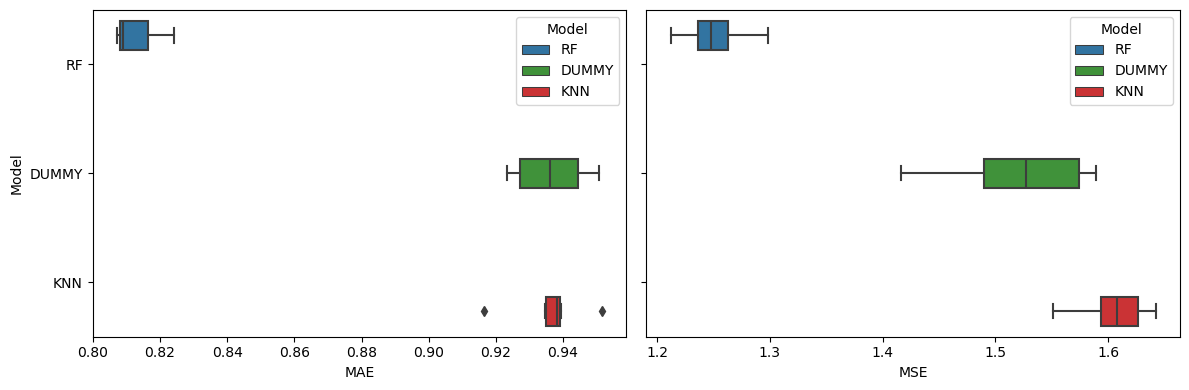

In [10]:
print(reg_metrics)
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", hue = 'Model', ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", hue = 'Model', ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

    TEAM_ID  PLAYER_ID  DATE_DIFF  OPPOSING_TEAM   WINRATE  LOCATION    SEASON
0  0.148341   0.331392   0.086066       0.210022  0.067038  0.042619  0.114523
1  0.156148   0.313004   0.086430       0.214820  0.069615  0.043828  0.116155
2  0.157640   0.309995   0.087746       0.214805  0.069730  0.043803  0.116280
3  0.158129   0.312547   0.086140       0.214701  0.067857  0.043519  0.117107
4  0.157812   0.310374   0.087207       0.214685  0.068773  0.044123  0.117026
5  0.158544   0.311942   0.086315       0.214316  0.070559  0.042357  0.115966
6  0.157381   0.310873   0.085869       0.216416  0.070722  0.043703  0.115035
7  0.157988   0.311410   0.086827       0.216061  0.066788  0.044137  0.116789


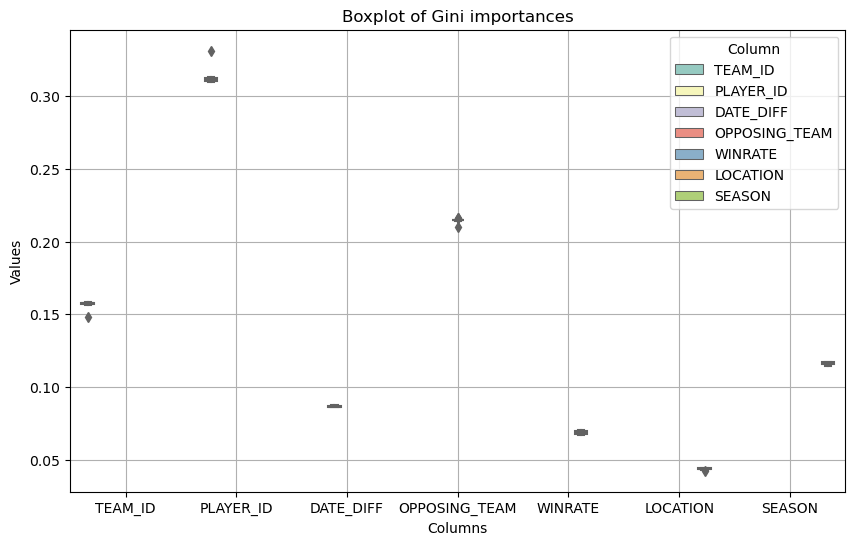

In [11]:
print(gini_importances)
melted_gini = gini_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Column', y='value', data=melted_gini, hue='Column', palette='Set3')

plt.title('Boxplot of Gini importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()